In [14]:
import matplotlib.pyplot as plt

In [3]:
import os
import sys
import numpy as np
import h5py

rng = np.random.RandomState(23455)

clip_near = 0.1
clip_far = 1000.0

cam_inv_proj = np.array([
    [-1.398332, -0.000000,  0.000000, -0.000000],
    [-0.000000,  0.786562, -0.000000,  0.000000],
    [ 0.000000, -0.000000,  0.000000, -1.000000],
    [-0.000000,  0.000000, -4.999500,  5.000499]])

cam_proj  = np.array([
    [-0.715138, 0.000000, -0.000000,  0.000000],
    [ 0.000000, 1.271356,  0.000000,  0.000000],
    [ 0.000000, 0.000000, -1.000200, -0.200020],
    [ 0.000000, 0.000000, -1.000000,  0.000000]])

def perspective_depth(d, n, f):
    return -((2 * n) / d - f - n) / (f - n)

def camera_space(D):
    D = perspective_depth(1-D, clip_near, clip_far) * 2.0 - 1.0
    U = np.empty((D.shape[0], D.shape[1], 2))
    U[:,:,0] = (((np.arange(D.shape[0])+0.5)/D.shape[0]) * 2.0 - 1.0)[:,np.newaxis]
    U[:,:,1] = (((np.arange(D.shape[1])+0.5)/D.shape[1]) * 2.0 - 1.0)[np.newaxis,:]
    P = np.concatenate([U[:,:,0:1], U[:,:,1:2], D, np.ones(D.shape)], axis=-1)
    P = cam_inv_proj.dot(P.reshape(-1,4).T).T.reshape(P.shape)
    return P[:,:,:3] / P[:,:,3:4]
    
nsamples = 1024
fw = 31
radius = 1.0
hw = int(((fw-1)/2))
coords = np.array([[x,y,0] for x in range(-hw, hw+1) for y in range(-hw, hw+1)], dtype=np.float) / hw

databases = [
    ('mesa1',      150),
    ('mesa2',      150),
    ('mesa3',      150),
    ('mesa4',      100),
    ('mesa_props', 100),
]

total_images = sum([nimages for (name, nimages) in databases])

X = np.empty((nsamples*total_images, fw, fw, 4), dtype=np.float32)
Y = np.empty((nsamples*total_images, 1), dtype=np.float32)

ii = 0

for name, nimages in databases:
    
    print('Processing Database "%s"' % name)
    
    for i in range(1, nimages+1):
        
        sys.stdout.write('\rProcessing Image %i of %i' % (i, nimages))
        
        S = np.fromfile('/home/yvan/Downloads/nnao_demo/data/raw/'+name+'/AO/'+name+'.'+str(i)+'.bin', dtype=np.float32).reshape(720, 1280, 1)
        N = np.fromfile('/home/yvan/Downloads/nnao_demo/data/raw/'+name+'/normalCam/'+name+'.'+str(i)+'.bin', dtype=np.float32).reshape(720, 1280, 4)
        N, D = N[:,:,:3], N[:,:,3:]
        
        S, N, D = np.swapaxes(S, 0, 1), np.swapaxes(N, 0, 1), np.swapaxes(D, 0, 1)
        W = camera_space(D)
        
        for _ in range(nsamples):
            x, y = rng.randint(S.shape[0]), rng.randint(S.shape[1])
        
            nexts = W[x,y] + radius * coords
            nexts = np.concatenate([nexts, np.ones((len(coords), 1))], axis=-1)
            nexts = cam_proj.dot(nexts.T).T
            nexts = (nexts[:,:2] / nexts[:,3:])*0.5+0.5
            
            indices = (
                np.clip(nexts[:,0]*W.shape[0], 0, W.shape[0]-1).astype(np.int),
                np.clip(nexts[:,1]*W.shape[1], 0, W.shape[1]-1).astype(np.int))

            length = np.sqrt(np.sum((W[indices] - W[x,y])**2, axis=-1))[...,np.newaxis]
            dists = 1.0 - np.clip(length / radius, 0, 1)
            
            X[ii] = np.concatenate([
                (N[indices] - N[x,y]) * dists,
                (W[indices] - W[x,y])[:,2:] * dists,
            ], axis=-1).reshape(fw, fw, 4)
            
            Y[ii] = S[x:x+1,y:y+1]
            
            ii += 1
            
        
    print('')
    
print(X.shape, Y.shape, ii)

Ymean = 0.0
Ystd = Y.reshape(-1, Y.shape[-1])[::100].std(axis=0, dtype=np.float64).astype(np.float32)
print(Ymean, Ystd)

Xmean = X.reshape(-1, X.shape[-1])[::100].mean(axis=0, dtype=np.float64).astype(np.float32)
Xstd = X.reshape(-1, X.shape[-1])[::100].std(axis=0, dtype=np.float64).astype(np.float32)
print(Xmean, Xstd)

f = h5py.File('database.hdf5', 'w')
f.create_dataset('X', data=X)
f.create_dataset('Y', data=Y)
f.create_dataset('Xmean', data=Xmean)
f.create_dataset('Xstd', data=Xstd)
f.create_dataset('Ymean', data=Ymean)
f.create_dataset('Ystd', data=Ystd)
f.close()

Processing Database "mesa1"
Processing Image 150 of 150
Processing Database "mesa2"
Processing Image 150 of 150
Processing Database "mesa3"
Processing Image 150 of 150
Processing Database "mesa4"
Processing Image 100 of 100
Processing Database "mesa_props"
Processing Image 100 of 100
(665600, 31, 31, 4) (665600, 1) 665600
0.0 [0.11618026]
[ 5.2099265e-05 -2.8511984e-06 -7.6131044e-05  4.5999829e-03] [0.04715738 0.05295582 0.03093803 0.05632147]


In [4]:
f = h5py.File("database.hdf5", "r")

N, width, height = f['X'].shape[:3]
Ymean, Ystd = np.array(f['Ymean']), np.array(f['Ystd'])
Xmean, Xstd = np.array(f['Xmean']), np.array(f['Xstd'])

In [5]:
N

665600

In [6]:
width

31

In [7]:
height

31

In [9]:
Ymean, Ystd

(array(0.), array([0.11618026], dtype=float32))

In [10]:
Xmean, Xstd

(array([ 5.2099265e-05, -2.8511984e-06, -7.6131044e-05,  4.5999829e-03],
       dtype=float32),
 array([0.04715738, 0.05295582, 0.03093803, 0.05632147], dtype=float32))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


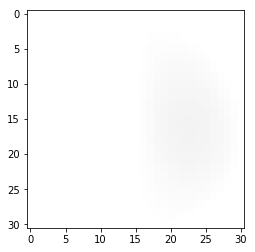

In [18]:
plt.imshow(f['X'][100])

In [20]:
f['X'][250].mean()

0.000127042

In [27]:
print(coords[:50])

[[-1.         -1.          0.        ]
 [-1.         -0.93333333  0.        ]
 [-1.         -0.86666667  0.        ]
 [-1.         -0.8         0.        ]
 [-1.         -0.73333333  0.        ]
 [-1.         -0.66666667  0.        ]
 [-1.         -0.6         0.        ]
 [-1.         -0.53333333  0.        ]
 [-1.         -0.46666667  0.        ]
 [-1.         -0.4         0.        ]
 [-1.         -0.33333333  0.        ]
 [-1.         -0.26666667  0.        ]
 [-1.         -0.2         0.        ]
 [-1.         -0.13333333  0.        ]
 [-1.         -0.06666667  0.        ]
 [-1.          0.          0.        ]
 [-1.          0.06666667  0.        ]
 [-1.          0.13333333  0.        ]
 [-1.          0.2         0.        ]
 [-1.          0.26666667  0.        ]
 [-1.          0.33333333  0.        ]
 [-1.          0.4         0.        ]
 [-1.          0.46666667  0.        ]
 [-1.          0.53333333  0.        ]
 [-1.          0.6         0.        ]
 [-1.          0.66666667

In [82]:
next_pts = W[1,5] + 1.0 * coords

In [83]:
next_pts = np.concatenate([next_pts, np.ones((len(coords), 1))], axis=-1)

In [84]:
next_pts

array([[ 8.17586759, -6.09451228, -6.57742514,  1.        ],
       [ 8.17586759, -6.02784562, -6.57742514,  1.        ],
       [ 8.17586759, -5.96117895, -6.57742514,  1.        ],
       ...,
       [10.17586759, -4.22784562, -6.57742514,  1.        ],
       [10.17586759, -4.16117895, -6.57742514,  1.        ],
       [10.17586759, -4.09451228, -6.57742514,  1.        ]])

In [90]:
cam_proj.shape, next_pts.T.shape

((4, 4), (4, 961))

In [85]:
next_cam = cam_proj.dot(next_pts.T).T

In [86]:
next_cam

array([[-5.84687359, -7.74829476,  6.37872062,  6.57742514],
       [-5.84687359, -7.66353769,  6.37872062,  6.57742514],
       [-5.84687359, -7.57878063,  6.37872062,  6.57742514],
       ...,
       [-7.27714959, -5.37509689,  6.37872062,  6.57742514],
       [-7.27714959, -5.29033983,  6.37872062,  6.57742514],
       [-7.27714959, -5.20558276,  6.37872062,  6.57742514]])

In [ ]:
cam_proj.dot

In [91]:
next_cam.shape

(961, 4)

In [39]:
nexts = (nexts[:,:2] / nexts[:,3:])*0.5+0.5

In [43]:
nexts, nexts.shape

(array([[ 0.05553477, -0.08900669],
        [ 0.05553477, -0.08256366],
        [ 0.05553477, -0.07612063],
        ...,
        [-0.05319137,  0.09139809],
        [-0.05319137,  0.09784112],
        [-0.05319137,  0.10428415]]), (961, 2))

In [47]:
indices = (np.clip(nexts[:,0]*W.shape[0], 0, W.shape[0]-1).astype(np.int),
                np.clip(nexts[:,1]*W.shape[1], 0, W.shape[1]-1).astype(np.int))

In [68]:
indices[0]

array([71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71,
       71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 66, 66, 66,
       66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66,
       66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 61, 61, 61, 61, 61, 61,
       61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
       61, 61, 61, 61, 61, 61, 61, 61, 57, 57, 57, 57, 57, 57, 57, 57, 57,
       57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
       57, 57, 57, 57, 57, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52,
       52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52,
       52, 52, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
       47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 43,
       43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
       43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 38, 38, 38, 38,
       38, 38, 38, 38, 38

In [57]:
length = np.sqrt(np.sum((W[indices] - W[x,y])**2, axis=-1))[...,np.newaxis]
dists = 1.0 - np.clip(length / 1.0, 0, 1)

In [65]:
length[:20]

array([[15.85577933],
       [15.85577933],
       [15.85577933],
       [15.85577933],
       [15.85577933],
       [15.85577933],
       [15.85577933],
       [15.85577933],
       [15.85577933],
       [15.85577933],
       [15.85577933],
       [15.85577933],
       [15.85577933],
       [15.85577933],
       [15.85577933],
       [15.80008271],
       [15.74512328],
       [15.70182531],
       [15.64834459],
       [15.59900609]])